## Results in this file are tested by the same model build in Anylogic (SIRV_open.alp), and the results are the same! Also same as the final model in the file "openPopulationSIRV_composition_by_Stocks" that composed via stocks!!

In [41]:
using AlgebraicStockFlow

using LabelledArrays
using OrdinaryDiffEq
using Plots
using JSON

using Catlab
using Catlab.CategoricalAlgebra
using Catlab.Graphics
using Catlab.Programs
using Catlab.Theories
using Catlab.WiringDiagrams

using LabelledArrays
using LinearAlgebra: mul!

using Catlab.WiringDiagrams
using Catlab.Programs.RelationalPrograms

## SIR model

In [43]:
# define parameter values for model sir
p_sir=(birthRate=0.001, c_beta=0.1, recRate=0.05, deathRate=0.001, vaccRate=0.1)

(birthRate = 0.001, c_beta = 0.1, recRate = 0.05, deathRate = 0.001, vaccRate = 0.1)

In [45]:
# define flows functions of model sir
f_birth(u,t)=p_sir.birthRate*(u.S+u.I+u.R)
f_inf(u,t)= p_sir.c_beta*u.S*u.I/(u.S+u.I+u.R)
f_rec(u,t)= p_sir.recRate*u.I
f_deathS(u,t)=u.S*p_sir.deathRate
f_deathI(u,t)=u.I*p_sir.deathRate
f_deathR(u,t)=u.R*p_sir.deathRate
f_vacc(u,t)=u.S*p_sir.vaccRate
f_infv(u,t)=10

f_infv (generic function with 1 method)

In [46]:
sir_LabelledStockFlow=LabelledStockFlow{Function, Int}((:birth=>f_birth, :inf=>f_inf, :rec=>f_rec, :deathS=>f_deathS, :deathI=>f_deathI, :deathR=>f_deathR, :vacc=>f_vacc, :infv=>f_infv), (:S,990)=>(:birth => (:inf,:deathS,:vacc)), (:I,10)=>((:inf,:infv) => (:rec,:deathI)),(:R,0)=>(:rec=>:deathR))


F,funcFlow,fname
1,f_birth,birth
2,f_inf,inf
3,f_rec,rec
4,f_deathS,deathS
5,f_deathI,deathI
6,f_deathR,deathR
7,f_vacc,vacc
8,f_infv,infv
S,initialValue,sname
1,990,S


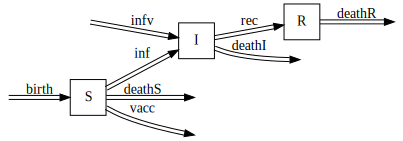

In [47]:
Graph(sir_LabelledStockFlow)

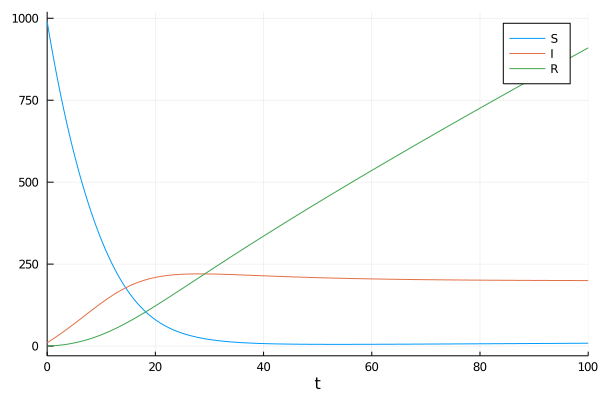

In [48]:
prob = ODEProblem(vectorfield(sir_LabelledStockFlow),initialValues(sir_LabelledStockFlow),(0.0,100.0),funcFlows(sir_LabelledStockFlow));
sol = solve(prob,Tsit5(),abstol=1e-8);
plot(sol)

In [49]:
sum(sol[24])

1118.1816613985613

## V part

In [71]:
p_v=LVector(vaccEffi=0.9)
f_vacc(u,t)=20
f_infv(u,t)=10
f_deathV(u,t)=u.V*p_sir.deathRate

f_deathV (generic function with 1 method)

In [51]:
v_LabelledStockFlow=LabelledStockFlow{Function, Int}((:infv=>f_infv, :vacc=>f_vacc, :deathV=>f_deathV), (:V,0)=>(:vacc => (:infv, :deathV)))


F,funcFlow,fname
1,f_infv,infv
2,f_vacc,vacc
3,f_deathV,deathV
S,initialValue,sname
1,0,V
I,ifn,is
1,2,1
O,ofn,os
1,1,1
2,3,1


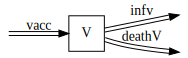

In [52]:
Graph(v_LabelledStockFlow)

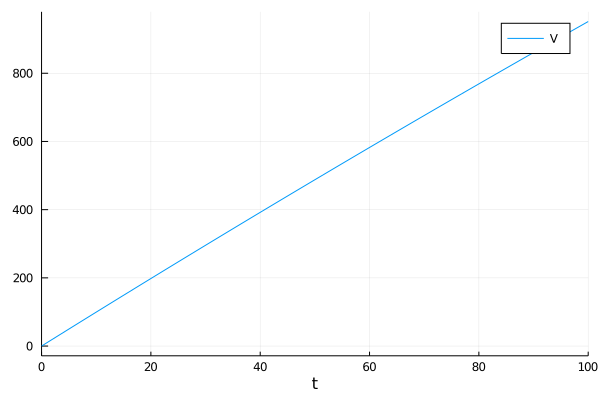

In [53]:
prob_v = ODEProblem(vectorfield(v_LabelledStockFlow),initialValues(v_LabelledStockFlow),(0.0,100.0),funcFlows(v_LabelledStockFlow));
sol_v = solve(prob_v,Tsit5(),abstol=1e-8);
plot(sol_v)

# Compose via flows of "f_vacc" and "f_infv"

## since flows have directions, we need to specify the two legs of the structured cospan. where the right leg of sir_sc_f is [:vacc, :infv], and the left leg of v_sc_f is [:vacc, :infv], that we can compose together!

In [54]:
sir_sc_f=Open_F([:birth],sir_LabelledStockFlow,[:vacc, :infv])

StructuredMulticospan{Catlab.CategoricalAlgebra.StructuredCospans.DiscreteACSet{Catlab.CSetDataStructures.AttributedCSet{Catlab.Theories.CatDesc{(:F,),(),(),()},Catlab.Theories.AttrDesc{Catlab.Theories.CatDesc{(:F,),(),(),()},(:FuncFlow, :InitialValue, :Name),(:funcFlow, :fname),(1, 1),(1, 3)},Tuple{Function,Int64,Symbol},(),(),Tables,Indices} where Indices<:NamedTuple where Tables<:NamedTuple,Catlab.CSetDataStructures.AttributedCSet{Catlab.Theories.CatDesc{(:F, :S, :I, :O),(:ifn, :is, :ofn, :os),(3, 3, 4, 4),(1, 2, 1, 2)},Catlab.Theories.AttrDesc{Catlab.Theories.CatDesc{(:F, :S, :I, :O),(:ifn, :is, :ofn, :os),(3, 3, 4, 4),(1, 2, 1, 2)},(:FuncFlow, :InitialValue, :Name),(:funcFlow, :initialValue, :sname, :fname),(1, 2, 2, 1),(1, 2, 3, 3)},Tuple{Function,Int64,Symbol},(:ifn, :is, :ofn, :os),(),Tables,Indices} where Indices<:NamedTuple where Tables<:NamedTuple},Multicospan{Catlab.CSetDataStructures.AttributedCSet{Catlab.Theories.CatDesc{(:F, :S, :I, :O),(:ifn, :is, :ofn, :os),(3, 3, 4, 4

In [55]:
v_sc_f=Open_F([:vacc, :infv],v_LabelledStockFlow,[:deathV])

StructuredMulticospan{Catlab.CategoricalAlgebra.StructuredCospans.DiscreteACSet{Catlab.CSetDataStructures.AttributedCSet{Catlab.Theories.CatDesc{(:F,),(),(),()},Catlab.Theories.AttrDesc{Catlab.Theories.CatDesc{(:F,),(),(),()},(:FuncFlow, :InitialValue, :Name),(:funcFlow, :fname),(1, 1),(1, 3)},Tuple{Function,Int64,Symbol},(),(),Tables,Indices} where Indices<:NamedTuple where Tables<:NamedTuple,Catlab.CSetDataStructures.AttributedCSet{Catlab.Theories.CatDesc{(:F, :S, :I, :O),(:ifn, :is, :ofn, :os),(3, 3, 4, 4),(1, 2, 1, 2)},Catlab.Theories.AttrDesc{Catlab.Theories.CatDesc{(:F, :S, :I, :O),(:ifn, :is, :ofn, :os),(3, 3, 4, 4),(1, 2, 1, 2)},(:FuncFlow, :InitialValue, :Name),(:funcFlow, :initialValue, :sname, :fname),(1, 2, 2, 1),(1, 2, 3, 3)},Tuple{Function,Int64,Symbol},(:ifn, :is, :ofn, :os),(),Tables,Indices} where Indices<:NamedTuple where Tables<:NamedTuple},Multicospan{Catlab.CSetDataStructures.AttributedCSet{Catlab.Theories.CatDesc{(:F, :S, :I, :O),(:ifn, :is, :ofn, :os),(3, 3, 4, 4

In [56]:
using Catlab.Theories

sirv_stockflow = apex(compose(sir_sc_f, v_sc_f))

F,funcFlow,fname
1,f_birth,birth
2,f_inf,inf
3,f_rec,rec
4,f_deathS,deathS
5,f_deathI,deathI
6,f_deathR,deathR
7,f_vacc,vacc
8,f_infv,infv
9,f_deathV,deathV
S,initialValue,sname


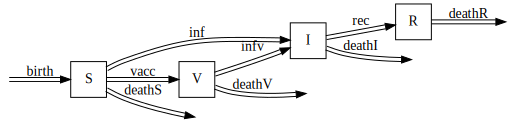

In [57]:
Graph(sirv_stockflow)

## Now, we need to modify the functions that need to be changed after composition. In this model, inlcudes: 1. flows relates to N(t). 2. flows need to be redefined, e.g., previous are constant, but now can be calculated by the composed stocks

### 1. flows related to N(t)

In [74]:
f_birth(u,t)=p_sir.birthRate*(u.S+u.I+u.R+u.V)
f_inf(u,t)= p_sir.c_beta*u.S*u.I/(u.S+u.I+u.R+u.V)


f_inf (generic function with 1 method)

### 2. flows need to be redefined

In [75]:
f_vacc(u,t)=u.S*p_sir.vaccRate
f_infv(u,t)=p_sir.c_beta*u.V*(1.0-p_v.vaccEffi)*u.I/(u.S+u.I+u.R+u.V)

f_infv (generic function with 1 method)

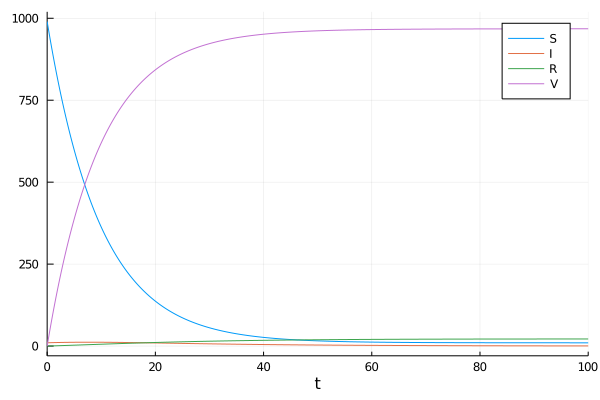

In [76]:
prob_sirv = ODEProblem(vectorfield(sirv_stockflow),initialValues(sirv_stockflow),(0.0,100.0),funcFlows(sirv_stockflow));
sol_sirv = solve(prob_sirv,Tsit5(),abstol=1e-8);
plot(sol_sirv)

In [77]:
sum(sol_sirv[24])

999.9999999999999

In [78]:
sol_sirv

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 24-element Array{Float64,1}:
   0.0
   1.428479607960636e-7
   1.5713275687566996e-6
   1.585612364836306e-5
   0.00015870408444442662
   0.0015871836924050624
   0.015871979772011418
   0.15871994056807498
   0.9842632884017855
   2.764741223599504
   5.2995411934132175
   8.494444029129193
  12.472696350816323
  17.168054422770904
  22.56559506187817
  28.568848204942277
  35.128845878664436
  42.19852371255741
  49.78479217987466
  57.950306127768044
  66.84551777754564
  76.70542964847874
  87.85275397270993
 100.0
u: 24-element Array{LArray{Float64,1,Array{Float64,1},(:S, :I, :R, :V)},1}:
 4-element LArray{Float64,1,Array{Float64,1},(:S, :I, :R, :V)}:
 :S => 990.0
 :I => 10.0
 :R => 0.0
 :V => 0.0
 4-element LArray{Float64,1,Array{Float64,1},(:S, :I, :R, :V)}:
 :S => 989.999985718061
 :I => 10.00000006856702
 :R => 7.14239806377969e-8
 :V => 1.4141948015691918e-5
 4-element LArray{Float64,1,Array{Float64